In [1]:
import numpy as np
np.seterr(invalid='ignore', divide='ignore')
from matplotlib import pyplot as plt
from matplotlib import colors

from numpy.random import rand
from scipy.stats import truncexpon

In [2]:
#######################################################################################################
########################################## USEFULL FUNCTIONS ##########################################
#######################################################################################################

### k-E relations ###
k2E = lambda k:81.8*(k/(2*np.pi))**2
E2k = lambda E:2*np.pi*np.sqrt(E/81.8)

### Q-theta relations ###
theta2Q = lambda omega, ki, theta: ki * np.sqrt(2 - omega/k2E(ki) - 2*np.sqrt(1 - omega/k2E(ki))*np.cos(theta))
Q2theta = lambda omega, ki, Q: np.arccos((2-Q**2/ki**2-omega/k2E(ki)) / (2*np.sqrt(1-omega/k2E(ki))))

##### dQ-dtheta relation #####
def dqdtheta(omega, ki, theta):
    a = 2-omega/k2E(ki)
    b = 2*np.sqrt(1-omega/k2E(ki))
    return ki**2/2 * b*np.sin(theta) / np.sqrt(a-b*np.cos(theta))

def dthetadq(omega, ki, Q):
    a = ki**2*(2-omega/k2E(ki))
    b = 2*ki**2*np.sqrt(1-omega/k2E(ki))
    return 2*Q/(b*np.sqrt(1-(a-Q**2)**2/b**2))


########################################################################################################
####################################### LINE-SOLID INTERCEPTIONS #######################################
########################################################################################################

############### Line parametrization ###############
def line_param(t, p, v):
    v = v/np.linalg.norm(v, axis=1)[:,None]
    return np.array([p[:,0] + v[:,0]*t, p[:,1] + v[:,1]*t, p[:,2] + v[:,2]*t]).T


############### CYLINDER ###############

### Line-cylinder intersection with p0 outside ###
# The interception is guaranteed by the given p and v, and happens on the cylinder and not on the plain boundaries. That is, whatch out for random p, v
def CylLine_inter_fromout(geom, p, v):
    # the incoming neutrons are aligned along x, therefor can hit only the vertical walls!
    r, h = geom[1:]
    v = v/np.linalg.norm(v, axis=1)[:,None]
  
    a = v[:,0]**2 + v[:,1]**2
    b = 2*(p[:,0]*v[:,0] + p[:,1]*v[:,1])
    c = p[:,0]**2 + p[:,1]**2 - r**2
    delta = b**2 - 4*a*c

    t1c, t2c = (-b + np.sqrt(delta))/(2*a), (-b - np.sqrt(delta))/(2*a)

    return np.sort((t1c, t2c), axis=0).T

### Line-cylinder intersection with p0 inside ###
# Only one foreword intercept is guaranteed, p is for shure inside the body
def CylLine_inter_fromin(geom, p, v):
    r, h = geom[1:]
    v = v/np.linalg.norm(v, axis=1)[:,None]

    ### cylinder
    a = v[:,0]**2 + v[:,1]**2
    b = 2*(p[:,0]*v[:,0] + p[:,1]*v[:,1])
    c = p[:,0]**2 + p[:,1]**2 - r**2
    delta = b**2 - 4*a*c

    tc = np.max([(-b + np.sqrt(delta))/(2*a), (-b - np.sqrt(delta))/(2*a)], axis=0) # take the higher t, that is the only one positive solution!

    ### planes
    tz = np.max([(h/2 - p[:,2])/v[:,2], (-h/2 - p[:,2])/v[:,2]], axis=0) # take the higher t, that is the only one positive solution!
    
    return np.sort((tc, tz), axis=0)[0].T


############### CUBOID ###############

### Line-cuboid intersection with p0 outside ###
def CubLine_inter_fromout(geom, p, v):
    # the incoming neutrons are aligned along x, therefor can hit only the x walls!
    dx, dy, dz = geom[1:]
    v = v/np.linalg.norm(v, axis=1)[:,None]
  
    # intercepts
    t1x, t2x = (-dx/2 - p[:,0])/v[:,0], (+dx/2 - p[:,0])/v[:,0]

    return np.sort([t1x, t2x])[:2].T

### Line-cuboid intersection with p0 inside ###
def CubLine_inter_fromin(geom, p, v):
    dx, dy, dz = geom[1:]
    v = v/np.linalg.norm(v, axis=1)[:,None]

    # intercepts
    tx = np.max([(-dx/2 - p[:,0])/v[:,0], (+dx/2 - p[:,0])/v[:,0]], axis=0)
    ty = np.max([(-dy/2 - p[:,1])/v[:,1], (+dy/2 - p[:,1])/v[:,1]], axis=0)
    tz = np.max([(-dz/2 - p[:,2])/v[:,2], (+dz/2 - p[:,2])/v[:,2]], axis=0)
    
    return np.min((tx, ty, tz), axis=0).T


############### ANULAR ###############

### Line-anular intersection with p0 outside ###
# The interception is guaranteed by the given p and v, and happens on the cylinder and not on the plain boundaries. That is, whatch out for random p, v
def AnuLine_inter_fromout(geom, p, v):
    r1, r2, h = geom[1:]
    v = v/np.linalg.norm(v, axis=1)[:,None]

    # the incoming neutrons are aligned along x, therefor can hit only the vertical walls!
    a = v[:,0]**2 + v[:,1]**2
    b = 2*(p[:,0]*v[:,0] + p[:,1]*v[:,1])

    c2 = p[:,0]**2 + p[:,1]**2 - r2**2
    delta2 = b**2 - 4*a*c2

    c1 = p[:,0]**2 + p[:,1]**2 - r1**2
    delta1 = b**2 - 4*a*c1

    t1c, t2c, t3c, t4c = (-b + np.sqrt(delta2))/(2*a), (-b - np.sqrt(delta2))/(2*a), (-b + np.sqrt(delta1))/(2*a), (-b - np.sqrt(delta1))/(2*a)
    # if no 4 intercepts, wh have nans!
    return np.sort((t1c, t2c, t3c, t4c), axis=0).T

### Line-anular intersection with p0 inside ###
# Only one foreword intercept is guaranteed, p is for shure inside the body
def AnuLine_inter_fromin(geom, p, v):
    r1, r2, h = geom[1:]
    v = v/np.linalg.norm(v, axis=1)[:,None]

    ### cylinders
    a = v[:,0]**2 + v[:,1]**2
    b = 2*(p[:,0]*v[:,0] + p[:,1]*v[:,1])

    c2= p[:,0]**2 + p[:,1]**2 - r2**2
    delta2 = b**2 - 4*a*c2

    c1 = p[:,0]**2 + p[:,1]**2 - r1**2
    delta1 = b**2 - 4*a*c1

    tc1 = np.max([(-b + np.sqrt(delta2))/(2*a), (-b - np.sqrt(delta2))/(2*a)], axis=0) # the external cylinder can have only one intercept!
    pc1 = line_param(tc1, p, v)
    tc1[(pc1[:,2]>h/2)|(pc1[:,2]<-h/2)] = np.nan  #check if it have!
    
    tc2, tc3 = (-b + np.sqrt(delta1))/(2*a), (-b - np.sqrt(delta1))/(2*a) # this can have 0, 1 or 2 intercept
    tc2[tc2<0] = np.nan # should be foreword
    tc3[tc3<0] = np.nan

    pc2 = line_param(tc2, p, v)
    tc2[(pc2[:,2]>h/2)|(pc2[:,2]<-h/2)] = np.nan # and should hapend in +-h/2
    pc3 = line_param(tc3, p, v)
    tc3[(pc3[:,2]>h/2)|(pc3[:,2]<-h/2)] = np.nan

    ### planes
    tz = np.max([(h/2 - p[:,2])/v[:,2], (-h/2 - p[:,2])/v[:,2]], axis=0)
    pz = line_param(tz, p, v)
    tz[((pz[:,0]**2 + pz[:,1]**2) < r1**2)|((pz[:,0]**2 + pz[:,1]**2) > r2**2)] = np.nan
    
    return  np.sort((tc1, tc2, tc3, tz), axis=0)[:3].T # in total, a maximum three intercepts|


########################################################################################################
########################################## NEUTRON GENERATION ##########################################
########################################################################################################

def ngen4Cyl(geom, x_init, N):
    r, h = geom[1:]
    return np.array([[-x_init]*N, rand(N) * 2*r - r, rand(N) * h - h/2]).T

def ngen4Cub(geom, x_init, N):
    dx, dy, dz = geom[1:]
    return np.array([[-x_init]*N, rand(N) * dy - dy/2, rand(N) * dz - dz/2]).T

def ngen4Anu(geom, x_init, N):
    r1, r2, h = geom[1:]
    return np.array([[-x_init]*N, rand(N) * 2*r2 - r2, rand(N) * h - h/2]).T

# Monte carlo simulation of inelastic multiple scattering

# Variables for simulation
Here we declare which are the foundamental inputs for the simulation.

## Geometry
The experimental geometry, i.e. the sample shape (within the cell): could be a cylinder, a cuboid or an anular cll.)

In [3]:
#####################
###### Geometry #####
#####################
geom = ('cylinder', 1.2, 3) # r, h
#geom = ('cuboid', 1, 3, 3) # dx, dy, dz
#geom = ('anular', 1.0, 1.2, 2) # r1, r2, h

In [4]:
### Experiment geometry ###
x_init = 100 #cm

### "detector" apertures
dtheta = 0.01
dphi = 0.01
domega = .1

In [5]:
if geom[0]=='cuboid':
    geom_type = 'convex'
    ngen = lambda N: ngen4Cub(geom, x_init, N)
    inter_fromout, inter_fromin = lambda p, v: CubLine_inter_fromout(geom, p, v), lambda p, v: CubLine_inter_fromin (geom, p, v)
elif geom[0]=='cylinder':
    geom_type = 'convex'
    ngen = lambda N: ngen4Cyl(geom, x_init, N)
    inter_fromout, inter_fromin = lambda p, v: CylLine_inter_fromout(geom, p, v), lambda p, v: CylLine_inter_fromin (geom, p, v)

elif geom[0]=='anular':
    geom_type = 'concave'
    ngen = lambda N: ngen4Anu(geom, x_init, N)
    inter_fromout, inter_fromin = lambda p, v: AnuLine_inter_fromout(geom, p, v), lambda p, v: AnuLine_inter_fromin (geom, p, v)

## Scattering geometry
Here we dfine the scattering geometry: the initial and final energy of the neutron, and the scattering angle.

In [6]:
####################################
##### Scattering configuration #####
####################################

### Incident energy ###
ki = 6.3788 #A^-1
Ei = k2E(ki) #meV

### Final energy ###
kf = 4.8738
Ef = k2E(kf)
omega = Ei - Ef

### Scattering angle / Q ###
theta = np.deg2rad(1)
Q = theta2Q(omega, ki, theta)

## Montecarlo reps
The number of Monte-Carlo repetitions, i.e. the number of neutron scattering events to simulate. Moreover, we initialize the N_bunch variable, foundamental to optimize the simulation (see in the notebook).

In [7]:
###############################
##### # of Montecrlo reps #####
###############################

N=1000000

N_bunch = 100

## Scattering lenghts

In [8]:
##############################
##### Scattering lenghts #####
##############################

mu_s = .361 #cm^-1
mu_abs = 0.0259 #cm^-1

## S(Q, $\omega$)
We load the S(Q, $\omega$) data on a mash evenly spaced in Q and $\omega$. We get:
$$
S_{i,j} = S(Q_i, \omega_j)
$$
with $Q_i$ a 1D Q vector evenly spaced at $dQ_{vec}$, and $\omega_j$ a 1D $\omega$ vector evenly spaced at $d\omega_{vec}$.
We also load the Q and $\omega$ vectors:
$$
Q_{i} \hspace{.5cm} i = 1, \ldots, N_{Q} \hspace{1cm} \text{and} \hspace{1cm} \omega_{i} \hspace{.5cm} i = 1, \ldots, N_{\omega}   
$$
And we create the $Q$ and $\omega$ meshes:
$$
Q_{i,j} = Q_i, \hspace{.5cm} j = 1, \ldots, N_{\omega} \hspace{1cm} \text{and} \hspace{1cm} \omega_{i,j} = \omega_j, \hspace{.5cm} i = 1, \ldots, N_Q   
$$


In [9]:
##################
##### S(Q,w) #####
##################
# 0: Vanadium -> S(Q,w) = exp(-omega^2/2sigma^2), sigma small
# 1: D-glycerol -> S(Q,w) is inelastic

##################
S_number = 1
##################

if S_number==0:
    S_mesh = np.load('./data_Sq/Sqw_vanadium/S_mesh.npy')
    Q_vec = np.load('./data_Sq/Sqw_vanadium/Q_vec.npy')
    omega_vec = np.load('./data_Sq/Sqw_vanadium/omega_vec.npy')
elif S_number==1:
    S_mesh = np.load('./data_Sq/Sqw_d-glycerol/S_mesh.npy')
    Q_vec = np.load('./data_Sq/Sqw_d-glycerol/Q_vec.npy')
    omega_vec = np.load('./data_Sq/Sqw_d-glycerol/omega_vec.npy')

# Usefull vectors
dQ_vec = Q_vec[1]-Q_vec[0]
domega_vec = omega_vec[1]-omega_vec[0]
Q_mesh, omega_mesh = np.meshgrid(Q_vec, omega_vec)
Q_mesh, omega_mesh = Q_mesh.T, omega_mesh.T

In [10]:
# Useful object for plots
S_imshow_extent = [omega_vec.min(),omega_vec.max(),Q_vec.max(),Q_vec.min()]

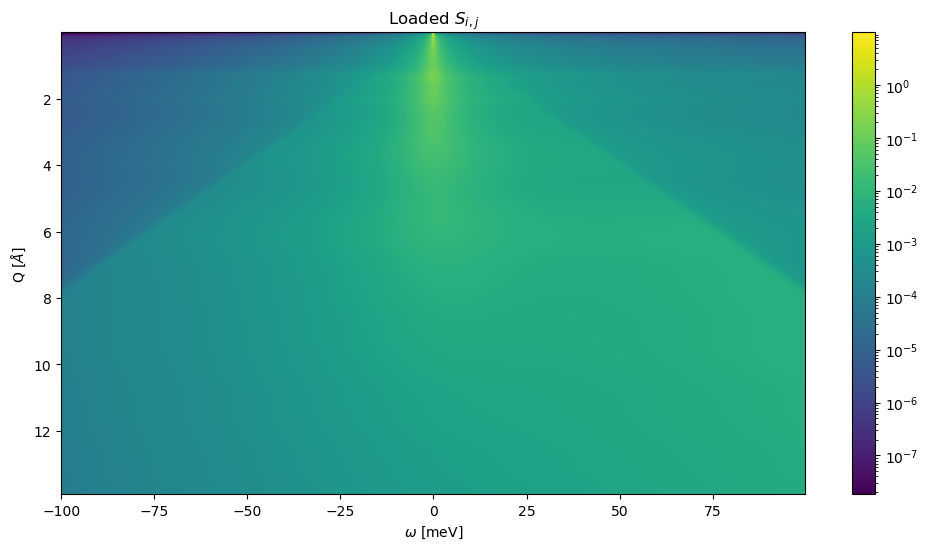

In [11]:
# plot
plt.figure(figsize=(12,6))
plt.title('Loaded $S_{i,j}$')
plt.imshow(S_mesh, norm='log', cmap='viridis', aspect='auto', extent=S_imshow_extent)
plt.xlabel('$\omega$ [meV]')
plt.ylabel('Q [$\AA$]')
plt.colorbar()

# Initial calculations
In this section we present the initial calculus needed for the simulation.

## Dynamc range for direct scattering event
The $\theta$-Q relations are:

$$
Q = ki \sqrt{2-\frac{\omega}{E_i}-2*\sqrt{1-\frac{\omega}{E_i}}\cos(\theta)} \hspace{1cm} cos(\theta) = \frac{k_i^2(2-\frac{\omega}{E_i})-Q^2}{2k_i^2\sqrt{2-\frac{\omega}{E_i}}}
$$
And these relations gives the kinematic range accessible by a neutron with an initial energy $E_i$:
$$
Q = ki \sqrt{2-\frac{\omega}{E_i}-2*\sqrt{1-\frac{\omega}{E_i}}\cos(\theta)} \hspace{1cm} \text{at} \hspace{1cm} cos\theta=1 \text{   } (\theta=0) \hspace{1cm} cos\theta=-1 \text{   } (\theta=180)
$$
Rewritten in python functions these relations are:

<code>theta2Q = lambda omega, ki, theta: ki * np.sqrt(2 - omega/k2E(ki) - 2*np.sqrt(1 - omega/k2E(ki))*np.cos(theta))</code>

<code>Q2theta = lambda omega, ki, Q: np.arccos((2-Q**2/ki**2-omega/k2E(ki)) / (2*np.sqrt(1-omega/k2E(ki))))</code>

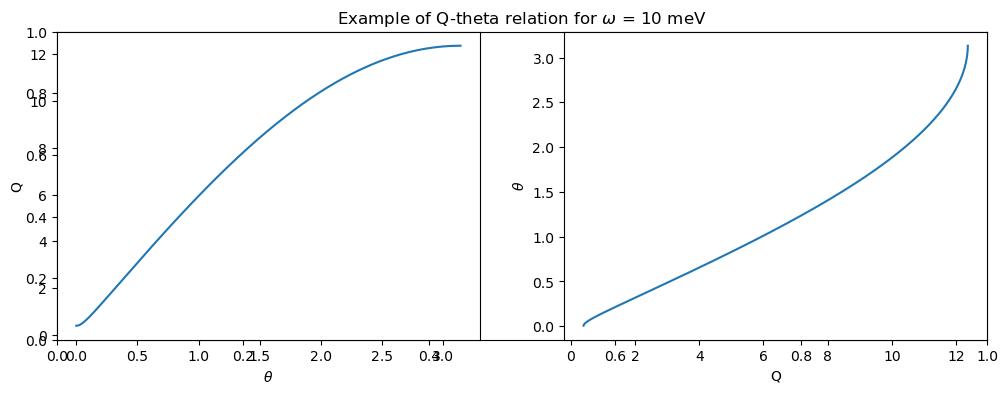

In [12]:
# plot
OMEGA = 10

X = np.linspace(0, np.pi, 1000)
Y = theta2Q(OMEGA, ki, X)

plt.figure(figsize=(12,4))
plt.title('Example of Q-theta relation for $\omega$ = %s meV' % OMEGA)
plt.subplot(1,2,1)
plt.plot(X,Y)
plt.xlabel(r'$\theta$')
plt.ylabel('Q')

X = np.linspace(0, 20, 10000)
Y = Q2theta(OMEGA, ki, X)

plt.subplot(1,2,2)
plt.plot(X,Y)
plt.ylabel(r'$\theta$')
plt.xlabel('Q');

To cure the divergent behaviour of the derivative we put a small upper and lower bound to the angle $\theta$ in $[d\theta_{min}, \pi-d\theta_{min}]$. Then, we obtain
$$
Q_{lowlim}[j] = k_i \sqrt{2-\frac{\omega_j}{E_i}-2*\sqrt{1-\frac{\omega_j}{E_i}}\cos(d\theta_{min})} \hspace{1cm} Q_{uplim}[j] = k_i \sqrt{2-\frac{\omega_j}{E_i}-2*\sqrt{1-\frac{\omega_j}{E_i}}\cos(\pi-d\theta_{min})}
$$
Were these Q limits are referred to the Q-omega meshes.

In [13]:
###############################################
##### Dynamic range for direct scattering #####
###############################################

dtheta_min = 0.01

Q_lowlim = lambda ki: ki * np.sqrt(2 - omega_vec/k2E(ki) - 2*np.sqrt(1 - omega_vec/k2E(ki))*np.cos(dtheta_min))
Q_uplim  = lambda ki: ki * np.sqrt(2 - omega_vec/k2E(ki) - 2*np.sqrt(1 - omega_vec/k2E(ki))*np.cos(np.pi-dtheta_min))

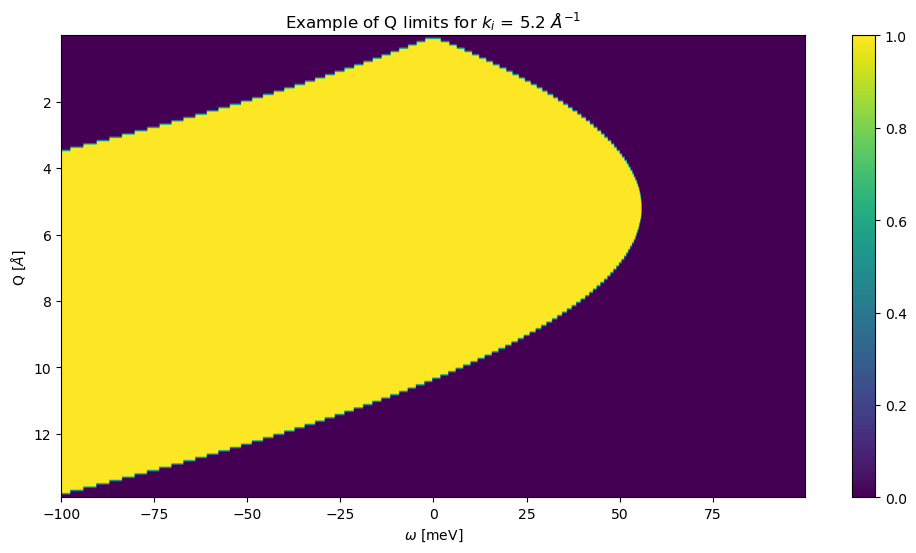

In [14]:
# usage example
k = 5.2 # chose the k value
out = (Q_mesh>Q_lowlim(k)) & (Q_mesh<Q_uplim(k))

# plot
plt.figure(figsize=(12,6))
plt.title('Example of Q limits for $k_i$ = %s $\AA^{-1}$' % k)
plt.imshow(out, aspect='auto', extent=S_imshow_extent)
plt.xlabel('$\omega$ [meV]')
plt.ylabel('Q [$\AA$]')
plt.colorbar();

## Cut of S(Q, $\omega$) for $k_i$
With the above computed Q limits we are now able to cut the S(Q, $\omega$) matrix in order to have only the values of S(Q, $\omega$) that are accessible by a neutron with an initial energy $E_i$. This is 
$$
S_{mask, E_i}[i,j] = 1 \hspace{.5cm} \text{if} \hspace{.5cm} Q_{lowlim}[j] \leq Q_i \leq Q_{uplim}[j], \hspace{.5cm} 0 \hspace{.5cm} \text{otherwise}
$$
$$
S_{cut, E_i}[i,j] = S_{mask, E_i}[i,j] * S_{i,j}

In [15]:
####################################
##### Cut of the S(Q,w) for Ei #####
####################################
S_mask_Ei = ((Q_mesh>Q_lowlim(ki)) & (Q_mesh<Q_uplim(ki)))
S_mesh_cutEi = S_mask_Ei * S_mesh

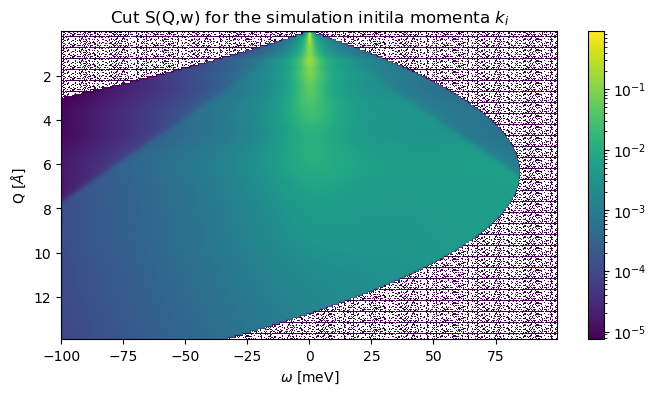

In [16]:
# plot
plt.figure(figsize=(8,4))
plt.title('Cut S(Q,w) for the simulation initila momenta $k_i$')
plt.imshow(S_mesh_cutEi, aspect='auto', norm='log', extent=S_imshow_extent)
plt.xlabel('$\omega$ [meV]')
plt.ylabel('Q [$\AA$]')
plt.colorbar();

## $d\theta$-dQ relation
A foundamental relation is the derivative of $\theta$ with respect to $Q$, needed t account the fact that the scattering probability $S(Q, \omega)$ is not evenly spaced in $\theta$ (it would be impossble) but in $Q$. The relation is:
$$
cos(\theta) = \frac{k_i^2(2-\frac{\omega}{E_i})-Q^2}{2k_i^2\sqrt{1-\frac{\omega}{E_i}}} = \frac{a-Q^2}{b}
$$
$$ a = k_i^2(2-\omega/E_i) \hspace{2cm} b=2k_i^2\sqrt{1-\omega/E_i}$$
$$ \Rightarrow \frac{d\theta}{dQ} = \frac{2Q}{b \sqrt{1-(a-Q^2)^2/b^2}} $$
And we can compute the derivative on the mesh as
$$ \frac{d\theta}{dQ}(k_i)_{i,j} = \frac{2Q_i}{b_{j} \sqrt{1-(a_{j}-Q_i^2)^2/b_{j}^2}} $$

<code>def dthetadq(omega, ki, Q):<br>
&nbsp;&nbsp;&nbsp;&nbsp; a = ki**2*(2-omega/k2E(ki))<br>
&nbsp;&nbsp;&nbsp;&nbsp; b = 2*ki**2*np.sqrt(1-omega/k2E(ki))<br>
&nbsp;&nbsp;&nbsp;&nbsp; return 2*Q/(b*np.sqrt(1-(a-Q**2)**2/b**2)) </code>

In [17]:
################################
##### dthetadQ on the mesh #####
################################
dthetadq_pdfEi = np.nan_to_num(dthetadq(omega_mesh, ki, Q_mesh)) * S_mask_Ei

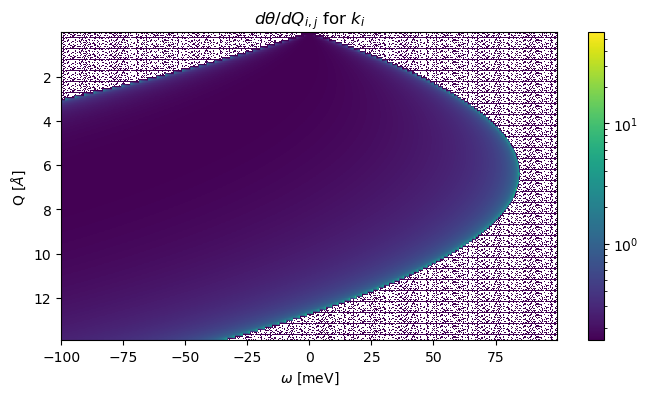

In [18]:
# plot
plt.figure(figsize=(8,4))
plt.title(r'$d\theta /dQ_{i,j}$ for $k_i$')
plt.imshow(dthetadq_pdfEi, aspect='auto', extent=S_imshow_extent, norm='log')
plt.xlabel('$\omega$ [meV]')
plt.ylabel('Q [$\AA$]')
plt.colorbar()

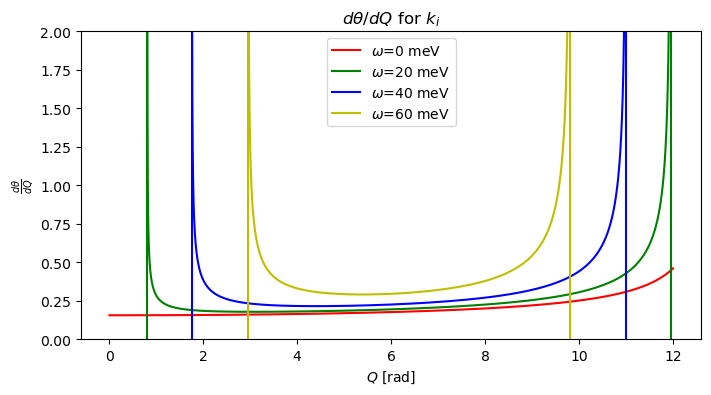

In [19]:
# plot
X = np.linspace(0, 12, 10000)

plt.figure(figsize=(8,4))
plt.title(r'$d\theta /dQ$ for $k_i$')
plt.plot(X, dthetadq(0, ki, X), label='$\omega$=0 meV', c='r')
plt.plot(X, dthetadq(20, ki, X), label='$\omega$=20 meV', c='g')
plt.axvline(theta2Q(20, ki, 0), c='g')
plt.axvline(theta2Q(20, ki, np.pi), c='g')
plt.plot(X, dthetadq(40, ki, X), label='$\omega$=40 meV', c='b')
plt.axvline(theta2Q(40, ki, 0), c='b')
plt.axvline(theta2Q(40, ki, np.pi), c='b')
plt.plot(X, dthetadq(60, ki, X), label='$\omega$=60 meV', c='y')
plt.axvline(theta2Q(60, ki, 0), c='y')
plt.axvline(theta2Q(60, ki, np.pi), c='y')

plt.ylim(0,2)

plt.xlabel(r'$Q$ [rad]')
plt.ylabel(r'$\frac{d\theta}{dQ}$')
plt.legend();

## $PDF_{S_{i,j}}$ normalization from the mash
Normalization of the PDF on the mash is done using:
$$
P(\theta_{i,j}\pm dQ_{vec}/2,\omega_{j}) \propto \sqrt{1-\frac{\omega_j}{E_i}}S_{i,j} d\omega d\theta_{i,j} \sin\theta_{i,j} d\phi = \sqrt{1-\frac{\omega_j}{E_i}} S_{i,j} d\omega (\frac{d\theta}{dQ})_{i,j} dQ_{vec} \sin\theta_{i,j} d\phi  \hspace{1cm} \text{with} \hspace{1cm} \theta_{i,j} = \theta(Q_{i},\omega_{j}), \hspace{0.5cm} d\theta_{i,j} = \frac{d\theta}{dQ}(Q_{i},\omega_{j}) dQ_{vec}
$$
and the PDF is finally
$$
PDF_{i,j} (k_i)= \frac{\sqrt{1-\frac{\omega_j}{E_i}}S_{i,j}}{\sum_{i,j} P_{i,j}}
$$

Onece we defined the probability density function, the probability of a scattering event in the solid angle $d\Omega = d\theta \sin\theta d\phi$ and $d\omega$ is
$$
P_{i,j} = PDF_{i,j} d\omega d\theta \sin\theta_{i,j} d\phi

In [20]:
################################
##### S(Q,w) normalization #####
################################
sintheta_meshEi = np.nan_to_num(np.sin(Q2theta(omega_mesh, ki, Q_mesh)))
PDF_Ei = np.nan_to_num(np.sqrt(1-omega_mesh/Ei)) * S_mesh_cutEi / (np.nan_to_num(np.sqrt(1-omega_mesh/Ei)) *  S_mesh_cutEi * domega * dthetadq_pdfEi * dQ_vec * sintheta_meshEi * dphi).sum()

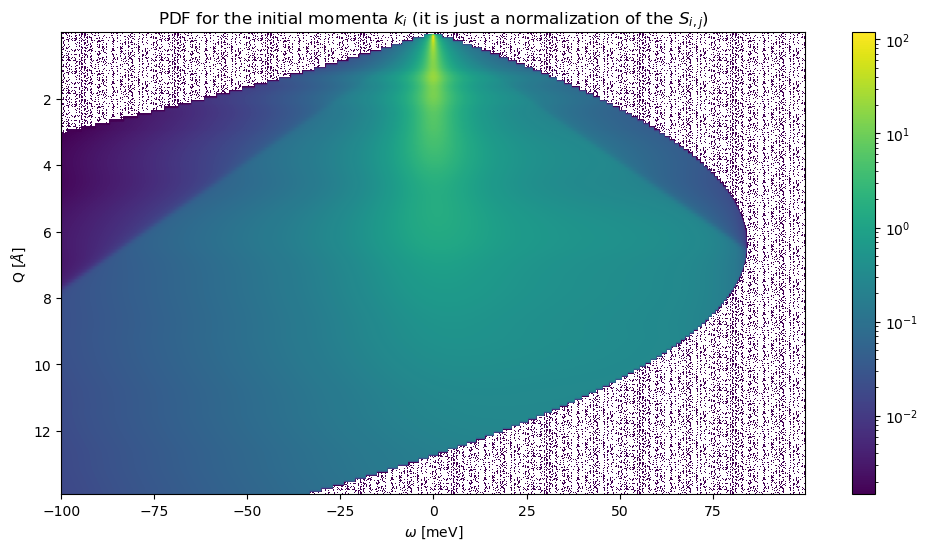

In [21]:
# plot
plt.figure(figsize=(12,6))
plt.title('PDF for the initial momenta $k_i$ (it is just a normalization of the $S_{i,j}$)')
plt.imshow(PDF_Ei, aspect='auto', extent=S_imshow_extent, norm='log')
plt.xlabel('$\omega$ [meV]')
plt.ylabel('Q [$\AA$]')
plt.colorbar()

## Lamber-Beer law

The Lamber-Beer law gives the scattering and absorption trasmissions $T_{s}$ and $T_{abs}$ of a path of lnght $d$:
$$
T_{s} = e^{-\mu_{s}d} \hspace{1cm} T_{abs} = e^{-\mu_{abs}d}
$$
where $\mu_{s}$ and $\mu_{abs}$ are the scattering and absorption coefficients.

The probability of having a scattering event within an intercept with trasmissions $T_{s}$ and $T_{abs}$ is
$$
P_{scattering} = (1-T_{s+abs}) - (1-T_{abs}) = T_{abs}-T_{s+abs} = T_{abs}(1-T_s)
$$
while the probability of trasmission on a path  with trasmissions $T_{s}$ and $T_{abs}$ is
$$
P_{trasmission} = T_{s}T_{abs}
$$

In [22]:
###########################
##### Lamber-Beer law #####
###########################

# Trasmission
T_s = lambda d: np.exp(-mu_s*d)
T_abs = lambda d: np.exp(-mu_abs*d)

# Random scattering extraction from Lamber-Beer law
rand_LB = lambda b: truncexpon.rvs(b = b*mu_s)/mu_s

# The simulation

## Randomly generate N neutrons at x=-x_init, uniform z and y
We generate N neutrons at x=-x_init, random z and y[-r, r]. The neutrons are generated with a fixed initial energy $E_i$. The beam is approximated to be uniform (for the sample dimsensions, i.e., $r_{sample} \ll r_{beam}$) and perfectly collimated ($\vec{k_i} = k_i\hat{x}$). We initialize the weights to 1:
$$
\vec{p_0} = (x_{init}, y_{rand}, z_{rand}) \hspace{1cm} \vec{k_0} = (k_i, 0, 0) \hspace{1cm} w_0 = 1

In [23]:
##########################
##### THE SIMULATION #####
##########################

##### RANDOMLY GENERATE N NEUTRONS #####
# from uniform beam at x=-x_init, random z = [-h/2, h/2] and y[-r, r]

p0 = ngen(N)
k0 = np.array([[ki, 0, 0]]*N)
w0 = np.array([1]*N)

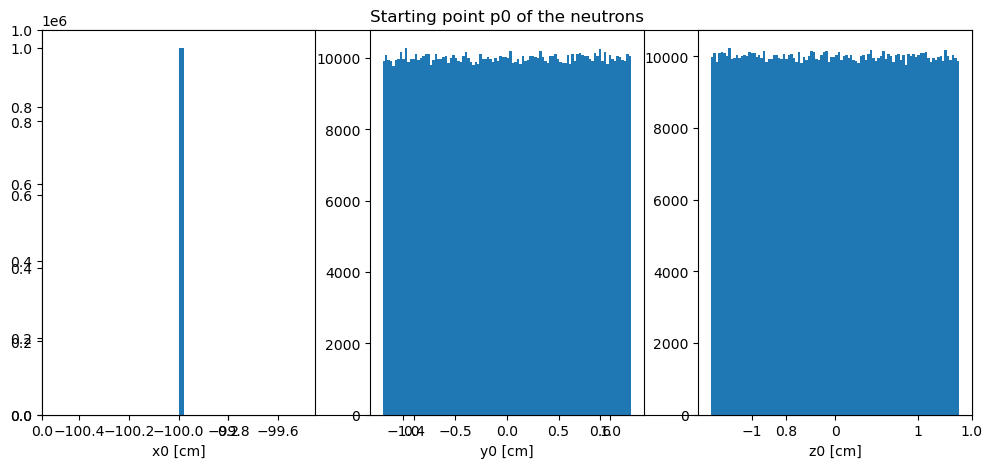

In [24]:
# plots
plt.figure(figsize=(12,5))
plt.title('Starting point p0 of the neutrons');
plt.subplot(1,3,1)
plt.hist(p0[:,0], bins=50)
plt.xlabel('x0 [cm]')
plt.subplot(1,3,2)
plt.hist(p0[:,1], bins=100)
plt.xlabel('y0 [cm]')
plt.subplot(1,3,3)
plt.hist(p0[:,2], bins=100)
plt.xlabel('z0 [cm]');



In [25]:
# dimensions of the vectors
print('p0:', p0.nbytes/1e6, 'MB')
print('k0:', k0.nbytes/1e6, 'MB')
print('w0:', w0.nbytes/1e6, 'MB')

p0: 24.0 MB
k0: 24.0 MB
w0: 8.0 MB


## Extract the 1st scattering position $p_0$
Here we extract a scattering position from the truncated Lamber-Beer PDF. First we compute the intercept between the incident neutron trajectory and the sample. This intercept have a lenght $d_1$. We therefore update the neutron probability to
$$ w_1 = w_0 (1-T_s(d_1))T_{abs}(d_1) $$
Then we extract a random position $p_1$ from the truncated Lamber-Beer distribution:
$$ PDF_{L-B\  trunc} = e^{-\mu_{s}x} \hspace{1cm} \text{with} \hspace{1cm} x = [0,d_1] $$
N.B. : Care must be taken in the case of non convex sample geometries, where voids must be taken into account!
The output of this subsection is therefor
$$ \vec{p_1} \hspace{1cm} \text{and} \hspace{1cm} w_1

In [26]:
##### EXTRACT THE 1ST SCATTERING POSITION #####

# intercept calculation
ts = inter_fromout(p0, k0)
ts = np.nan_to_num(ts)
if geom_type=='convex':
    ts = np.append(ts, np.zeros((N,2)), axis=1)
if geom_type=='concave':
    pass
d1 = (ts[:,1] - ts[:,0]) + (ts[:,3] - ts[:,2])
# weigth update
w1 = w0*(1-T_s(d1))*T_abs(d1)
# dtp2 extraction (one for all)
dtp2 = rand_LB(d1)
# generate void vector
void = np.where(dtp2<=(ts[:, 1]-ts[:, 0]), 0, ts[:,2] - ts[:,1])

p1 = line_param(ts[:,0] + dtp2 + void, p0, k0)

Text(0.5, 0, 'd1 [cm]')

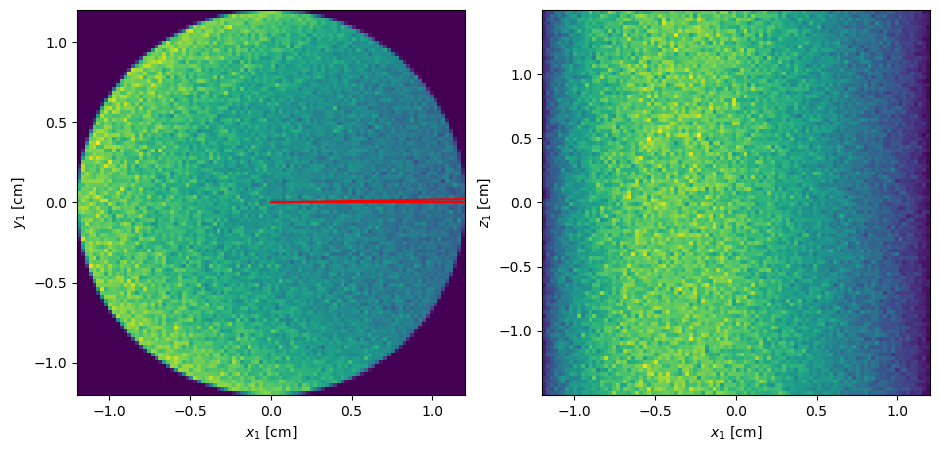

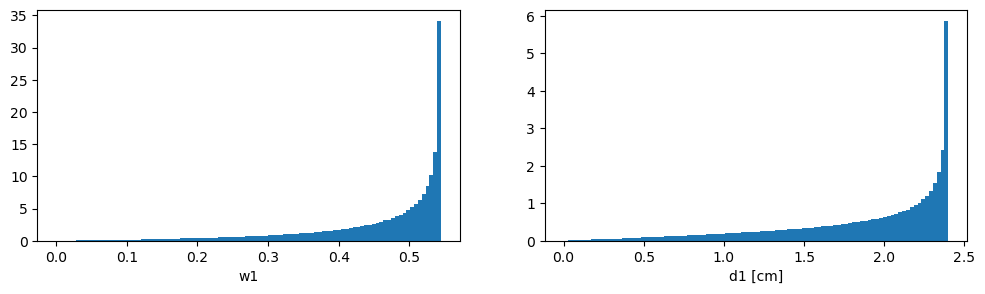

In [27]:
# plots

# heatmap
plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
plt.hist2d(p1[:,0], p1[:,1], bins=100, weights=w1);
X = np.linspace(0, p1[:,0].max(), 100)
plt.plot(X, X*np.sin(theta), c='r')
plt.plot(X, X*np.sin(0), c='r')
plt.xlabel(r'$x_1$ [cm]')
plt.ylabel(r'$y_1$ [cm]')
plt.subplot(1,2,2)
plt.hist2d(p1[:,0], p1[:,2], bins=100, weights=w1);
plt.xlabel(r'$x_1$ [cm]')
plt.ylabel(r'$z_1$ [cm]')

# 2D
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.hist(w1, bins=100, density=True);
plt.xlabel('w1')
plt.subplot(1,2,2)
plt.hist(d1, bins=100, density=True);
plt.xlabel('d1 [cm]')

## Probability of single scattering
From the point $\vec{p_1}$ we compute the probability of a single scattering event. The scattering angle $\theta$ is fixed by the input parameters (scattering geometry), as well as the final momenta ($k_f$):
$$ k_{1s} = k_f * (cos(\theta), sin(\theta), 0) $$
It is than easy to compute the exchanged energy and momentum:
$$ \omega = E_i - E_f $$
$$ Q = |k_i - k_f|$$

In [28]:
### PROBABILITY OF SINGLE SCATTERING ###

# Find k1, omega1, Q1 imposing collimator angle
k1s = kf * np.array([np.cos(theta), np.sin(theta), 0]) * np.ones((N, 3))
Q1s = np.linalg.norm(k0 - k1s, axis=1)
omega1s = (Ei - Ef) * np.ones(N)
theta1s = theta

And finaly we get the single scattering probability from the above defined $PDF_{S_{i,j}}$, remembering
$$ P(\theta_{i,j},\omega_{j}) = PDF_{i,j} (k_i) d\omega d\theta \sin\theta_{i,j} d\phi$$
The weight update become:
$$ w_{1s} = w_1 PDF_{i,j} (k_i) d\omega d\theta \sin\theta_{i,j} d\phi $$

In [29]:
# Get the scattering probavilities from the PDF
Q_idx = np.searchsorted(Q_vec, Q1s)
omega_idx = np.searchsorted(omega_vec, omega1s)

w1s = w1 * PDF_Ei[Q_idx, omega_idx] * domega * dtheta * sintheta_meshEi[Q_idx, omega_idx] * dphi

And the final point for single scattering probability is accounting for the trasmission to the detector. Another time we have to compute the intercept from $\vec{p_1}$ to the detector, of lenght $d_{2s}$, and update the weight:
$$ w_{fs} = w_{1s} T_s(d_{2s}) T_{abs}(d_{2s}) $$
And this is our final single scattering probability for the neutron!

In [30]:
# intercept calculation
ts = inter_fromin(p1, k1s)
ts = np.nan_to_num(ts)
if geom_type=='convex':
    ts = np.column_stack([ts, np.zeros((N,2))])
if geom_type=='concave':
    pass

d2s = ts[:,0] + (ts[:,2] - ts[:,1])

# weigth update
wfs = w1s*T_s(d2s)*T_abs(d2s)

## Multiple scattering path

### Extraction from the S(Q, omega)
Here we have to extract a scattering direction and energy from the S(Q, $\omega$) matrix. Note that this extraction is independent from the point $\vec{p_1}$.

All the generated neutrons, at this point, feature the same momenta direction (along $\hat{x}$) and energy $E_i$. We first have to extract a random Q and $\omega$ from the S(Q, $\omega$) mesh. The relation:
$$ \frac{d\sigma}{d\Omega d\omega} \propto \sqrt{1-\frac{\omega}{E_i}}S(Q(\theta), \omega) $$
says that the probability of a scattering event in the solid angle $d\Omega = d\theta \sin\theta d\phi$ and $d\omega$ is proportional to the $S(Q(\theta), \omega)$, that is we should extract from this PDF in the $\theta$-$\omega$ space. But S is not evenly spaced in $\theta$! By means of the Jacobian $\frac{d\theta}{dQ}$ we can generate a weight vector from whuich we can extract the events:
$$ W_{i,j} \propto \sqrt{1-\frac{\omega_j}{E_i}}S_{i,j} d\omega d\theta_{i,j} \sin\theta_{i,j} d\phi = \sqrt{1-\frac{\omega_j}{E_i}}S_{i,j} d\omega (\frac{d\theta}{dQ})_{i,j} dQ_{vec} \sin\theta_{i,j} d\phi \hspace{1cm} \text{imposing} \hspace{1cm} \sum_{i,j} W_{i,j} = 1$$

We therefor extract
$$ Q_{1m} \hspace{1cm} \text{and} \hspace{1cm} \omega_{1m} $$
from which we compute
$$ \theta_{1m} = \theta(k_i, Q_{1m}, \omega1m) \hspace{1cm} \text{and} \hspace{1cm} E_{1m} = E_i - \omega1m $$
The weight update is
$$ w_{1m} = w_1 \hspace{1cm} (\text{as we imposed that the scattering event must happen}) $$
Via a uniform random number we obtain the final momenta vector:
$$ \vec{k}_{1m} = k_{1m}(E_{1m}) * (\cos(\theta_{1m}), \sin(\theta_{1m}) \cos(\phi_{1m}), \sin(\theta_{1m}) \sin(\phi_{1m})) $$

In [31]:
####################################
##### MULTIPLE SCATTERING PATH #####
####################################

### EXTRACTION FROM S(q,W) ###

# Probaility mesh for random choiches
W = np.nan_to_num(np.sqrt(1-omega_mesh/Ei)) * S_mesh_cutEi * dthetadq_pdfEi * sintheta_meshEi # * dQ_vec * domega * dphi
W /= W.sum()

# Random extractions
is_mesh = np.random.choice(np.arange(W.size), p=W.reshape(-1), size=N)

# Extracted scattering variables
Q1m = Q_mesh.reshape(-1)[is_mesh]
omega1m = omega_mesh.reshape(-1)[is_mesh]
theta1m = Q2theta(omega1m, ki, Q1m)
E1m = Ei - omega1m
w1m = w1

# Random angle on the scattering cone
phi1m = rand(N)*2*np.pi

# Neutrom momenta after scattering
k1m = (np.array((np.cos(theta1m), np.sin(theta1m)*np.cos(phi1m), np.sin(theta1m)*np.sin(phi1m))) * E2k(E1m)).T
k1m_mod = E2k(E1m)

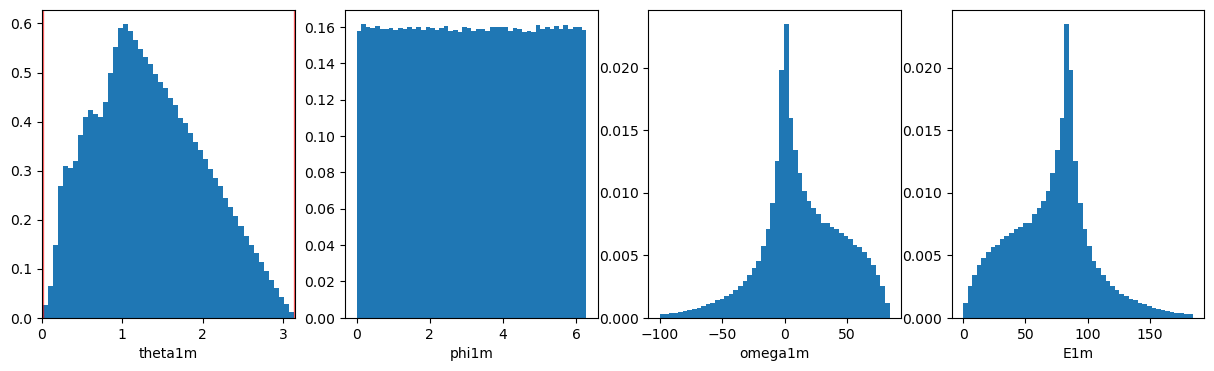

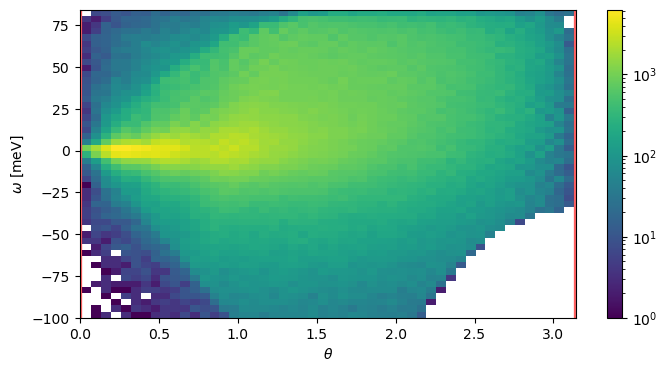

In [32]:
# plot
# 2D
plt.figure(figsize=(15,4))
plt.subplot(1,4,1)
plt.hist(theta1m, bins=50, density=True);
plt.axvspan(0, dtheta_min, alpha=0.5, color='red')
plt.axvspan(np.pi-dtheta_min, np.pi, alpha=0.5, color='red')
plt.xlabel('theta1m')
plt.xlim(0, np.pi)
plt.subplot(1,4,2)
plt.hist(phi1m, bins=50, density=True);
plt.xlabel('phi1m')
plt.subplot(1,4,3)
plt.hist(omega1m, bins=50, density=True);
plt.xlabel('omega1m')
plt.subplot(1,4,4)
plt.hist(E1m, bins=50, density=True);
plt.xlabel('E1m')

# 3D
plt.figure(figsize=(8,4))
plt.hist2d(theta1m, omega1m, bins=50, norm='log');
plt.ylabel('$\omega$ [meV]')
plt.xlabel(r'$\theta$')
plt.colorbar()
plt.xlim(0, np.pi)

plt.axvspan(0, dtheta_min, alpha=0.5, color='red')
plt.axvspan(np.pi-dtheta_min, np.pi, alpha=0.5, color='red')

Text(0, 0.5, '$k_{1m,z}$ [cm]')

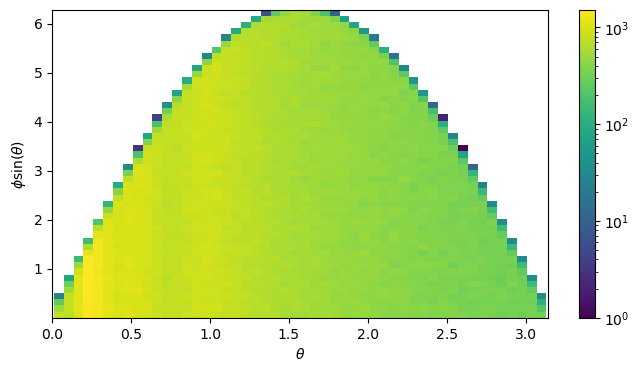

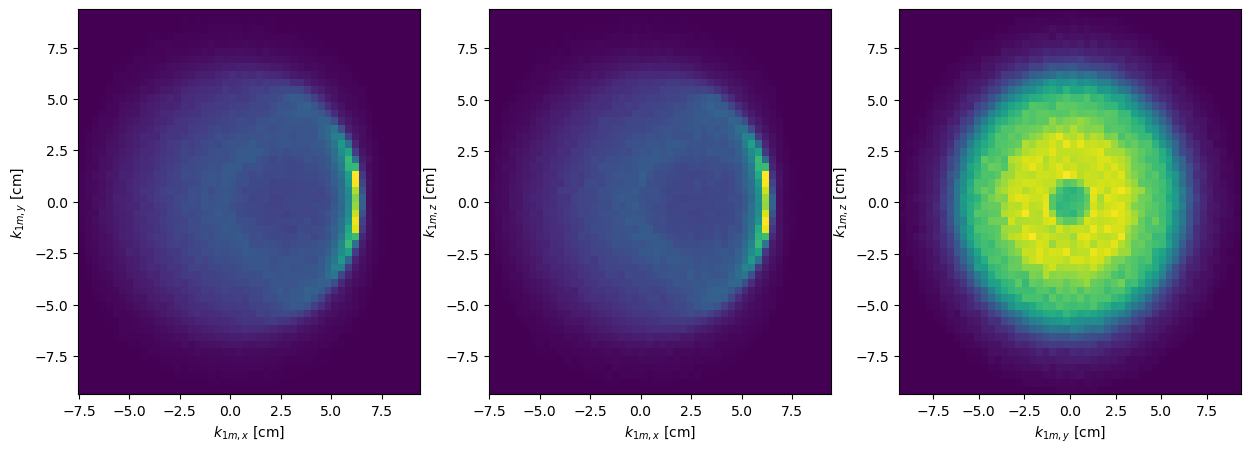

In [33]:
# plot
# heatmap
plt.figure(figsize=(8,4))
plt.hist2d(theta1m, phi1m*np.sin(theta1m), bins=50, norm='log');
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\phi \sin(\theta)$')
plt.colorbar()
plt.xlim(0, np.pi)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist2d(k1m[:,0], k1m[:,1], bins=50);
plt.xlabel(r'$k_{1m,x}$ [cm]')
plt.ylabel(r'$k_{1m,y}$ [cm]')
plt.subplot(1,3,2)
plt.hist2d(k1m[:,0], k1m[:,2], bins=50);
plt.xlabel(r'$k_{1m,x}$ [cm]')
plt.ylabel(r'$k_{1m,z}$ [cm]')
plt.subplot(1,3,3)
plt.hist2d(k1m[:,1], k1m[:,2], bins=50);
plt.xlabel(r'$k_{1m,y}$ [cm]')
plt.ylabel(r'$k_{1m,z}$ [cm]')

### Extract the 2nd scattering position for multiple
We now have to extract the 2nd scattering position for the multiple scattering event. We have to compute the intercept between the new neutron trajectory and the sample (this time from inside the sample). The lenght of this intercept is $d_{2m}$. The weight update is
$$ w_{2m} = w_{1m} (1-T_s(d_{2m})) T_{abs}(d_{2m}) $$
Then we extract a random position $p_{2m}$ from the truncated Lamber-Beer distribution:
$$ PDF_{L-B\  trunc} = e^{-\mu_{s}x} \hspace{1cm} \text{with} \hspace{1cm} x = [0,d_{2m}] $$

In [34]:
# intercept calculation
ts = inter_fromin(p1, k1m)
ts = np.nan_to_num(ts)
if geom_type=='convex':
    ts = np.column_stack([ts, np.zeros((N,2))])
if geom_type=='concave':
    pass

d2m = ts[:,0] + (ts[:,2] - ts[:,1])

# weigth update
w2 = w1m*(1-T_s(d2m))*T_abs(d2m)

# dtp2 extraction (one for all)
dtp2 = rand_LB(d2m)

# generate void vector
void = np.where(dtp2<=ts[:, 0], 0,ts[:,1] - ts[:,0])

p2 = line_param(dtp2 + void, p1, k1m)

Text(0, 0.5, '$z_2$ [cm]')

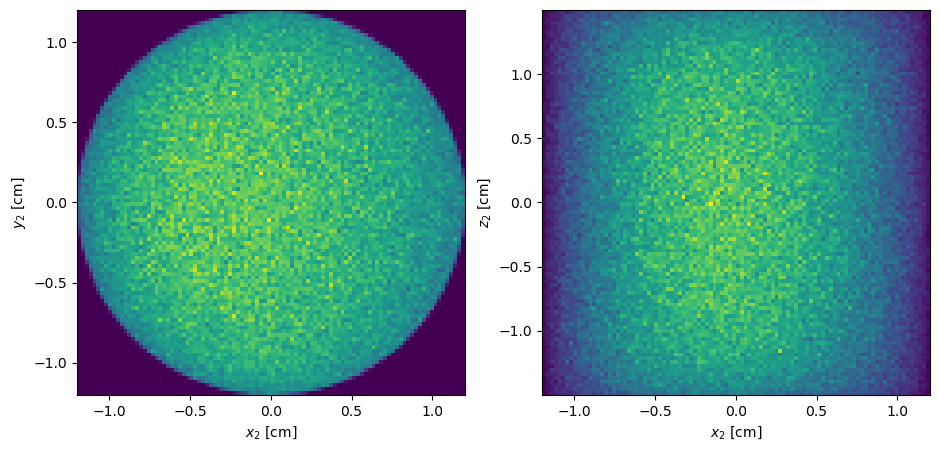

In [35]:
# plot
plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
plt.hist2d(p2[:,0], p2[:,1], bins=100, weights=w2);
plt.xlabel(r'$x_2$ [cm]')
plt.ylabel(r'$y_2$ [cm]')
plt.subplot(1,2,2)
plt.hist2d(p2[:,0], p2[:,2], bins=100, weights=w2);
plt.xlabel(r'$x_2$ [cm]')
plt.ylabel(r'$z_2$ [cm]')

### Probability of the 2nd scattering event reaching the detector
We first find $k_{2m}$ and $\omega_{2m}$ imposing the collimator (detector) angle:
$$ k_{2m} = k_f * (\cos(\theta), \sin(\theta), 0) $$
$$ \omega_{2m} = E_{1m} - E_f $$
$$ Q_{2m} = |k_{1m} - k_f|$$
$$ \theta_{2m} = \theta(k_{1m}, Q_{2m}, \omega_{2m}) $$

In [36]:
### Find k2m, omega2m, Q2m imposing collimator angle ###
k2m = kf * np.array([np.cos(theta), np.sin(theta), 0]) * np.ones((N, 3))
omega2m = (E1m - Ef) * np.ones(N)
Q2m = np.linalg.norm(k1m - k2m, axis=1)

theta2m = Q2theta(omega2m, E2k(E1m), Q2m)

MINOR CORRECTION: we should eliminate (mask) events outside of our $S(Q, \omega)$ mesh. This is later done by setting the weight to 0 if the event is outside the mesh.

In [37]:
### Mask of impossible events
mask2m = ~((Q2m>Q_vec.max()) | (Q2m<Q_vec.min()) | (omega2m>omega_vec.max()) | (omega2m<omega_vec.min()) | np.isnan(theta2m))

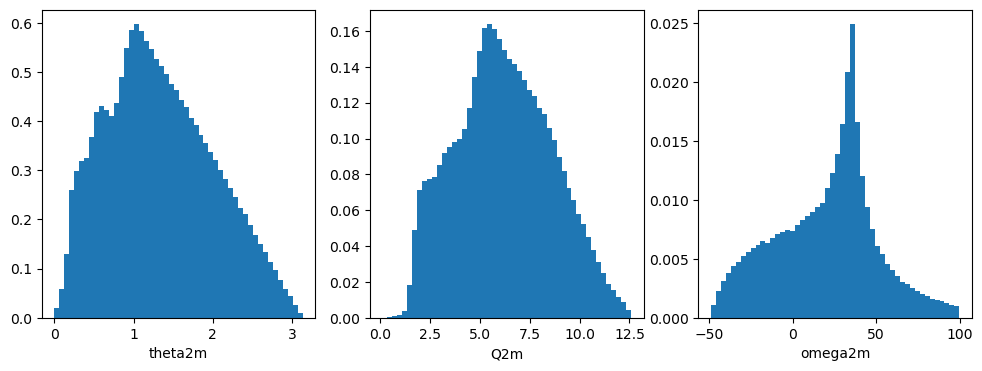

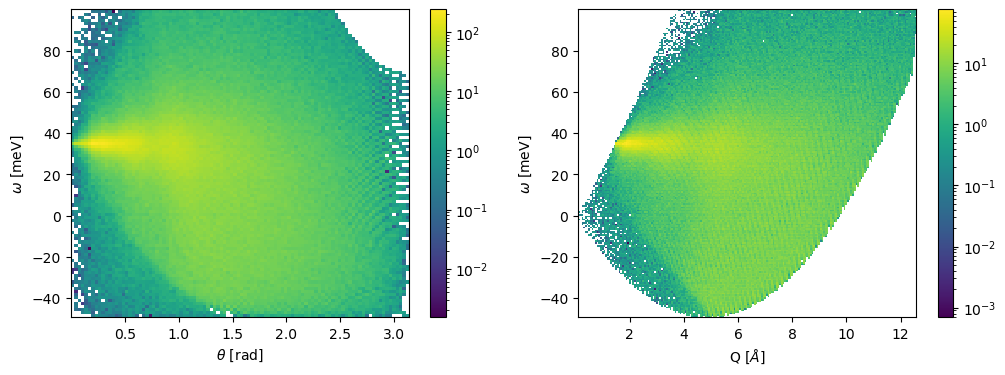

In [38]:
# plot
# 1D
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(theta2m[mask2m], bins=50, density=True);
plt.xlabel('theta2m')
plt.subplot(1,3,2)
plt.hist(Q2m[mask2m], bins=50, density=True);
plt.xlabel('Q2m')
plt.subplot(1,3,3)
plt.hist(omega2m[mask2m], bins=50, density=True);
plt.xlabel('omega2m')

# 2D
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist2d(theta2m[mask2m], omega2m[mask2m], bins=100, norm=colors.LogNorm(), weights=w2[mask2m]);
plt.ylabel('$\omega$ [meV]')
plt.xlabel(r'$\theta$ [rad]')
plt.colorbar()

plt.subplot(1,2,2)
plt.hist2d(Q2m[mask2m], omega2m[mask2m], bins=200, norm=colors.LogNorm(), weights=w2[mask2m]);
plt.ylabel('$\omega$ [meV]')
plt.xlabel('Q [$\AA$]')
plt.colorbar()

Next, we should compute the scattering probability associated with the computed $\theta_{2m}$ (or $Q_{2m}$) and $\omega_{2m}$. This is done by computing the PDF from the $S(Q, \omega)$ mesh. The difficulty this time lies in the fact that the neutron initial energy change neutron by neutron, therefore $\theta_{2m}$, $\frac{d\theta}{dQ}$ and the kinematic range change neutron by neutron!
For speeding up the simulation the key point here is to **bunch the energies**, computing the $S(Q, \omega)$ cut and the derivative $\frac{d\theta}{dQ}$ for all the neutrons in the bunch with an approximated energy $k_{i,\ bunch}$.

The calculation of the $PDF_{S_{i,j}}(k_{i,\ bunch})$ and the associated probability $P(\theta_{2m}, \omega_{2m}) = PDF_{i,j} (k_{i,\ bunch}) d\omega d\theta \sin\theta_{2m} d\phi$ is the same as for the single scattering event, but with the bunch energy $k_{i,\ bunch}$.
The weight update is therefore:
$$ w_{2m} = w_{2m} PDF_{i,j} (k_{i,\ bunch}) d\omega d\theta \sin\theta_{2m} d\phi $$

In [39]:
### SCATTERING PROBABILITIES FROM THE PDF $$$

# Bunching the initial energies E1m
E_min = E1m[mask2m].min()
E_max = E1m[mask2m].max()
bunch = np.linspace(E_min, E_max, N_bunch)[1:]
dbunch = (bunch[1]-bunch[0])

# find the bunch indexes
bunch_idx = np.searchsorted(bunch, E1m, side='left')
bunch_idx[~mask2m] = -1 # putting impossible events with idx=-1, i.e. in the next part P stay 0

# indexing Q2m and omega2m on the mesh
Q_idx = np.searchsorted(Q_vec, Q2m)
omega_idx = np.searchsorted(omega_vec, omega2m)

# calculating probabilities at bunches
P = np.zeros(N)

for b in range(N_bunch-1):
    # Mask
    mask = ((Q_mesh>Q_lowlim(E2k(bunch[b]-dbunch/2))) & (Q_mesh<Q_uplim(E2k(bunch[b]-dbunch/2))))
    # sintheta mesh
    sintheta_mesh = np.nan_to_num(np.sin(Q2theta(omega_mesh, E2k(bunch[b]-dbunch/2), Q_mesh)))
    # S cut
    S_mesh_cut = mask * S_mesh * np.nan_to_num( np.sqrt(1 - omega_mesh/(bunch[b]-dbunch/2)))

    # dthetadQ on the mesh
    dthetadq_pdf = np.nan_to_num(dthetadq(omega_mesh, E2k(bunch[b]-dbunch/2), Q_mesh)) * mask
    # normalization
    S_mesh_cut /= (S_mesh_cut * domega * dthetadq_pdf * dQ_vec * sintheta_mesh * dphi).sum()

    P[bunch_idx==b] = S_mesh_cut[Q_idx[bunch_idx==b], omega_idx[bunch_idx==b]] * domega * dtheta * sintheta_mesh[Q_idx[bunch_idx==b], omega_idx[bunch_idx==b]] * dphi
    
# updating the weights
w2m = w2 * P

### Trasmission of multiple events to the detector
The final point for multiple scattering probability is accounting for the trasmission to the detector. Another time we have to compute the intercept from $\vec{p_2}$ to the detector, of lenght $d_{2m}$, and update the weight:
$$ w_{fm} = w_{2m} T_s(d_{3m}) T_{abs}(d_{3m}) $$


In [40]:
# intercept calculation
ts = inter_fromin(p1, k2m)
ts = np.nan_to_num(ts)
if geom_type=='convex':
    ts = np.column_stack([ts, np.zeros((N,2))])
if geom_type=='concave':
    pass

d3m = ts[:,0] + (ts[:,2] - ts[:,1])

# weigth update
wfm = w2m*T_s(d3m)*T_abs(d3m)

## Final results
The final result, that is, the relative intensity between single and multiple scattering events, is given by the average of the single and multiple scattering weights:
$$ I_s = \frac{1}{N} \sum_{i=1}^{N} w_{fs} $$
$$ I_m = \frac{1}{N} \sum_{i=1}^{N} w_{fm} $$

In [41]:
Is = wfs.mean()
Im = wfm.mean()

print('Is : {:0.2e}'.format(Is))
print('Im : {:0.2e}'.format(Im))
print('Im/Is = {:0.2f}'.format(Im/Is))

Is : 5.77e-09
Im : 3.38e-07
Im/Is = 58.62


## Data analysis


Text(0.5, 0, '$Q_{1m}$')

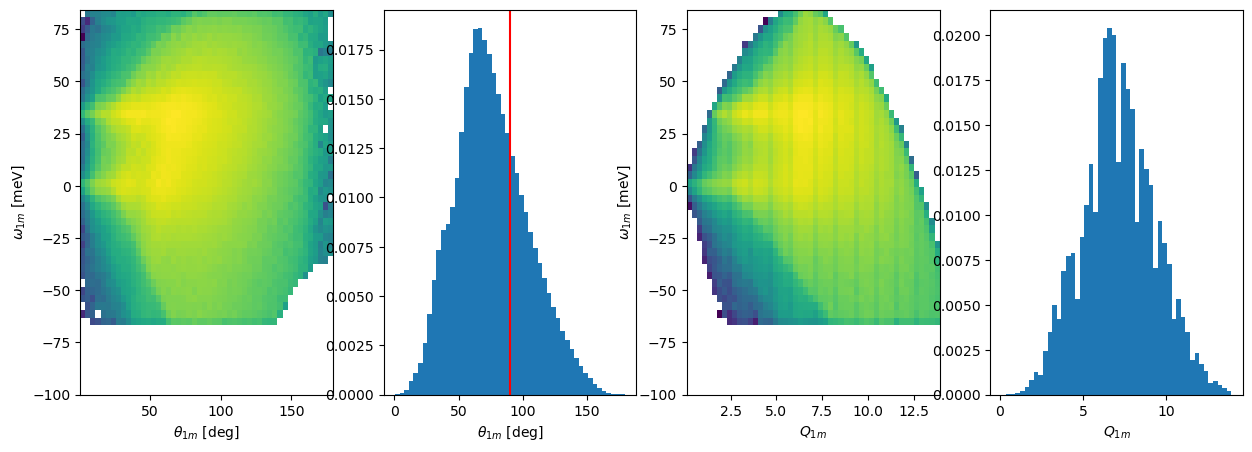

In [42]:
# heatmap
plt.figure(figsize=(15,5))
plt.subplot(1,4,1)
plt.hist2d(np.rad2deg(theta1m), omega1m, bins=50, weights=wfm, norm='log');
plt.xlabel(r'$\theta_{1m}$ [deg]')
plt.ylabel('$\omega_{1m}$ [meV]')

plt.subplot(1,4,2)
plt.hist(np.rad2deg(theta1m), bins=50, weights=wfm);
plt.axvline(90, c='r')
plt.xlabel(r'$\theta_{1m}$ [deg]')

plt.subplot(1,4,3)
plt.hist2d(Q1m, omega1m, bins=50, weights=wfm, norm='log');
plt.xlabel(r'$Q_{1m}$')
plt.ylabel('$\omega_{1m}$ [meV]')

plt.subplot(1,4,4)
plt.hist(Q1m, bins=50, weights=wfm);
plt.xlabel(r'$Q_{1m}$')

Text(0.5, 0, '$Q_{2m}$')

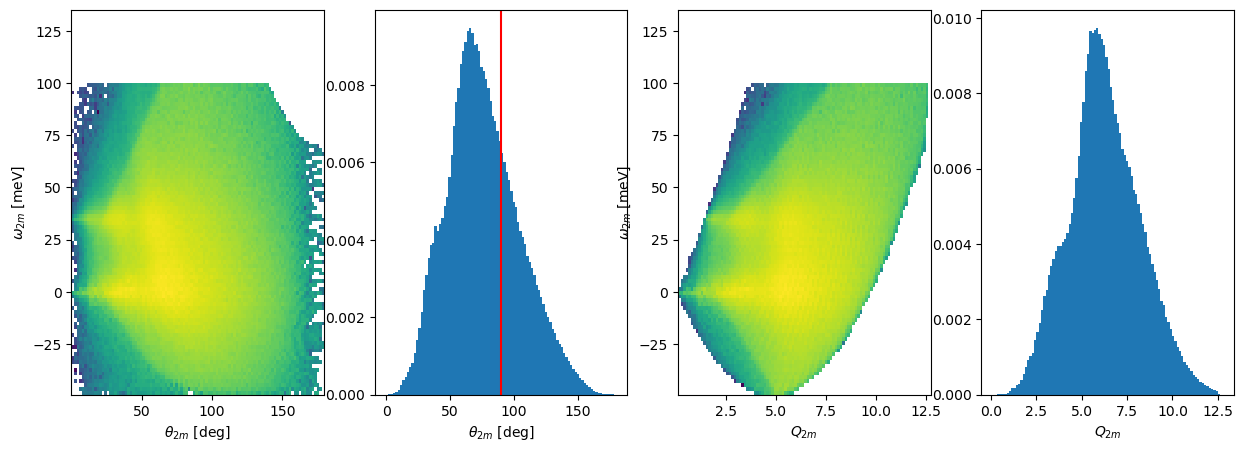

In [43]:
# heatmap
plt.figure(figsize=(15,5))
plt.subplot(1,4,1)
plt.hist2d(np.rad2deg(theta2m), omega2m, bins=100, weights=wfm, norm='log');
plt.xlabel(r'$\theta_{2m}$ [deg]')
plt.ylabel('$\omega_{2m}$ [meV]')

plt.subplot(1,4,2)
plt.hist(np.rad2deg(theta2m), bins=100, weights=wfm);
plt.axvline(90, c='r')
plt.xlabel(r'$\theta_{2m}$ [deg]')

plt.subplot(1,4,3)
plt.hist2d(Q2m, omega2m, bins=100, weights=wfm, norm='log');
plt.xlabel(r'$Q_{2m}$')
plt.ylabel('$\omega_{2m}$ [meV]')

plt.subplot(1,4,4)
plt.hist(Q2m, bins=100, weights=wfm);
plt.xlabel(r'$Q_{2m}$')